In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("/Users/katieli/Research/wheelchair/data/raw/SubMax/HYB/ALP_submax_HYB.csv")
df['power_z[W]'] = df['gyro_z_R[rad/s]']*df['moment_z_R[Nm]']

In [2]:
cycle_stats = df.groupby('cycle[count]').agg({
    'speed_L[km/h]': ['max', 'mean'],  # peak and mean speed per cycle
    'power_z[W]': ['max', 'mean'],  # assuming you calculate power
    'moment_z_R[Nm]': ['max', 'mean'], # assuming you calculate torque
    'time[sec]': 'min'  # cycle start time
}).reset_index()

# Flatten column names
cycle_stats.columns = ['cycle', 
                       'peak_speed', 'mean_speed', 
                        'peak_power', 'mean_power',
                        'peak_torque', 'mean_torque', 'time']

In [15]:
import matplotlib.pyplot as plt

# 2. Rolling std (detects stability)
window_size = 3
cycle_stats['power_std'] = cycle_stats['mean_power'].rolling(window_size).std()
cycle_stats['torque_std'] = cycle_stats['mean_torque'].rolling(window_size).std()

# 3. Mark steady-state (relax threshold to get ~40+ cycles)
power_threshold = cycle_stats['power_std'].quantile(0.9)  # bottom 90%
torque_threshold = cycle_stats['torque_std'].quantile(0.9)
cycle_stats['is_steady_state'] = (
    (cycle_stats['power_std'] < power_threshold) & 
    (cycle_stats['torque_std'] < torque_threshold)
)

# 4. Select 40 typical cycles from 1-60s window
time_window = cycle_stats[
    (cycle_stats['time'] >= 1) & 
    (cycle_stats['time'] <= 60) &
    (cycle_stats['is_steady_state'])
]

median_speed = time_window['peak_speed'].median()
time_window['diff'] = np.abs(time_window['peak_speed'] - median_speed)
selected = time_window.nsmallest(40, 'diff')

print(f"Selected {len(selected)} cycles")
print(f"Median speed: {median_speed:.2f}")
print(f"First acceptable cycles:{selected['cycle'].min()}")
print(f"Acceptable cycles: time_window

Selected 40 cycles
Median speed: 23.82
First acceptable cycles:7


/var/folders/19/4g92jwjd61zcj030pc5pld7m0000gn/T/ipykernel_72163/3173909416.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_window['diff'] = np.abs(time_window['peak_speed'] - median_speed)


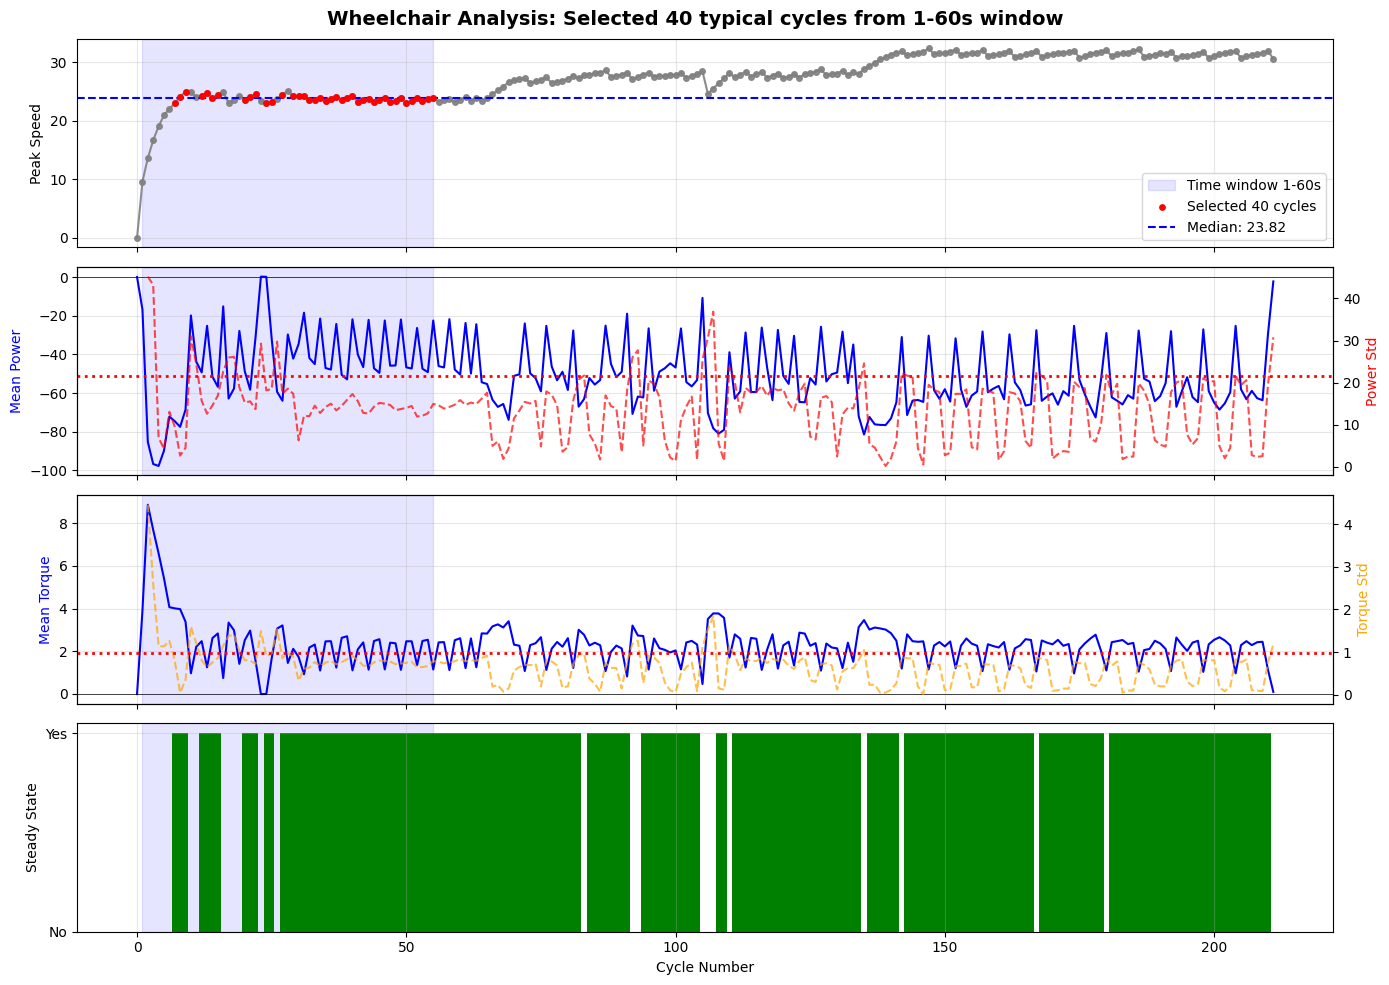

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# Highlight time window of interest (1-60s)
for ax in axes:
    ax.axvspan(cycle_stats[cycle_stats['time'] >= 1]['cycle'].min(),
               cycle_stats[cycle_stats['time'] <= 60]['cycle'].max(),
               alpha=0.1, color='blue', label='Time window 1-60s')

# Plot 1: Peak Speed with selected cycles
axes[0].plot(cycle_stats['cycle'], cycle_stats['peak_speed'], 'o-', markersize=4, color='gray', alpha=0.9)
axes[0].scatter(selected['cycle'], selected['peak_speed'], c='red', s=15, zorder=5, label='Selected 40 cycles')
axes[0].axhline(y=median_speed, color='blue', linestyle='--', label=f'Median: {median_speed:.2f}')
axes[0].set_ylabel('Peak Speed')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Power with rolling std
ax2_twin = axes[1].twinx()
axes[1].plot(cycle_stats['cycle'], cycle_stats['mean_power'], 'b-', linewidth=1.5)
ax2_twin.plot(cycle_stats['cycle'], cycle_stats['power_std'], 'r--', alpha=0.7)
ax2_twin.axhline(y=power_threshold, color='r', linestyle=':', linewidth=2, label='Threshold')
axes[1].set_ylabel('Mean Power', color='b')
ax2_twin.set_ylabel('Power Std', color='r')
axes[1].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
axes[1].grid(True, alpha=0.3)

# Plot 3: Torque with rolling std
ax3_twin = axes[2].twinx()
axes[2].plot(cycle_stats['cycle'], cycle_stats['mean_torque'], 'b-', linewidth=1.5)
ax3_twin.plot(cycle_stats['cycle'], cycle_stats['torque_std'], 'orange', linestyle='--', alpha=0.7)
ax3_twin.axhline(y=torque_threshold, color='r', linestyle=':', linewidth=2, label='Threshold')
axes[2].set_ylabel('Mean Torque', color='b')
ax3_twin.set_ylabel('Torque Std', color='orange')
axes[2].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
axes[2].grid(True, alpha=0.3)

# Plot 4: Steady-state detection
colors = ['red' if not ss else 'green' for ss in cycle_stats['is_steady_state']]
axes[3].bar(cycle_stats['cycle'], cycle_stats['is_steady_state'], color=colors, width=1.0)
axes[3].set_ylabel('Steady State')
axes[3].set_xlabel('Cycle Number')
axes[3].set_yticks([0, 1])
axes[3].set_yticklabels(['No', 'Yes'])
axes[3].grid(True, alpha=0.3)

plt.suptitle(f'Wheelchair Analysis: Selected {len(selected)} typical cycles from 1-60s window', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()